# Flavor Transformations

This notebook produces the figures in the SNEWPY paper showing the effect of the flavor transformation prescriptions upon the nakazato-shen-z0.004-t_rev100ms-s20.0 model 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy, MixingParameters
from snewpy.models.ccsn import Nakazato_2013
from snewpy.models.presn import Patton_2017
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes


In [2]:
mpl.rc('font', size=18)

In [2]:
nfile = '../../models/Nakazato_2013/nakazato-shen-z0.004-t_rev100ms-s20.0.fits'
n = Nakazato_2013(nfile)
pfile = '../../models/presn-models/models/Patton_2017/totalLuminosity_15SolarMass.dat'
p = Patton_2017(pfile)

In [4]:
print(n, '\n\n', p)

Nakazato_2013 Model: nakazato-shen-z0.004-t_rev100ms-s20.0.fits
Progenitor mass  : 20.0 solMass
EOS              : SHEN
Metallicity      : 0.004
Revival time     : 100.0 ms 

 Patton_2017 Model: totalLuminosity_15SolarMass
Progenitor Mass  : 15.0 solMass


## Transformed and untransformed energy integrated flux at Earth

Compute and plot the flux at Earth for a SN at 10 kpc with no flavor transformation, and with the chosen flavor transformation.

In [12]:
def plot_total_flux(model, xform_nmo, xform_imo, presn=False):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    """
    
    energies = np.linspace(0,60,121) * u.MeV    
    if presn:
        energies = np.linspace(0,20,101) * u.MeV
    d = (10*u.kpc).to('cm').value # distance to SN
        
    times = model.get_time()
    burst_epoch = times <= 0.1*u.s
    accretion_epoch = (times > 0.1*u.s) & (times <= 0.5*u.s)
    cooling_epoch = (times > 0.5*u.s) & (times <= 10*u.s)
    if presn: # the following epochs are for Patton_2017
        burst_epoch = times <= 0.1*u.hour
        accretion_epoch = (times > 0.1*u.hour) & (times <= 2*u.hour)
        cooling_epoch = times > 2*u.hour
    
    ilum = {}
    olum_nmo = {}
    olum_imo = {}
    
    for flavor in Flavor:
        ilum[flavor] = np.zeros(len(times))
        olum_nmo[flavor] = np.zeros(len(times))
        olum_imo[flavor] = np.zeros(len(times))

    # Compute the transformed and untransformed flux at each time.
    for i, t in enumerate(times):
        ispec = model.get_initial_spectra(t, energies)
        ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
        ospec_imo = model.get_transformed_spectra(t, energies, xform_imo)

        for flavor in Flavor:
            for j, E in enumerate(energies):
                ispec[flavor][j] /= (4.*np.pi*d**2)
                ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
                ospec_imo[flavor][j] /= (4.*np.pi*d**2)
        
        for flavor in Flavor:
            ilum[flavor][i] = np.trapz(ispec[flavor].to('1/(erg*s)'), energies.to('erg')).value 
            olum_nmo[flavor][i] = np.trapz(ospec_nmo[flavor].to('1/(erg*s)'), energies.to('erg')).value
            olum_imo[flavor][i] = np.trapz(ospec_imo[flavor].to('1/(erg*s)'), energies.to('erg')).value            
            
    # make the figures 
    fig, axes = plt.subplots(3,3, figsize=(20,12), tight_layout=True)
    
    smax = [0.,0.,0.]
    titles = ['Untransformed', 'Transformed (NMO)', 'Transformed (IMO)']
    for i, spec in enumerate([ilum, olum_nmo, olum_imo]):
        for j, phase in enumerate([burst_epoch, accretion_epoch, cooling_epoch]):
            ax = axes[i,j]
            timeunits = 'ms' if j==0 else 's'
                
            for flavor in Flavor:
                if i == 0:
                    smax[j] = np.maximum(smax[j], 1.1*np.max(spec[flavor][phase]))
                    
                ax.plot(times[phase].to(timeunits),
                        spec[flavor][phase], label=flavor.to_tex(), lw=3,
                        color='C0' if flavor.is_electron else 'C1',
                        ls='-' if flavor.is_neutrino else ':')
            
            ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),
                   ylim=(0, smax[j]))
            
            if j==0:
               ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
               ax.legend(loc='upper right', ncol=1, fontsize=18)
            if j==1:
                ax.set(title=titles[i])
            if i < 2:
                ax.set(xticklabels=[])
            else:
                ax.set(xlabel='time [{}]'.format(timeunits))
            
            ax.grid(ls=':')

      
    return fig

## Untransformed and Transformed Spectra at Earth

Compute and plot the spectra at Earth for a SN at 10 kpc with no flavor transformation, and with the chosen flavor transformation.

In [13]:
def plot_spectra(model, xform_nmo, xform_imo, t, presn=False):
    """Plot initial and oscillated neutrino luminosities.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    """

    energies = np.linspace(0,60,121) * u.MeV   
    if presn: energies = np.linspace(0,20,101) * u.MeV   
    d = (10*u.kpc).to('cm').value # distance to SN

    #get the spectra
    ispec = model.get_initial_spectra(t, energies) 
    ospec_nmo = model.get_transformed_spectra(t, energies, xform_nmo)
    ospec_imo = model.get_transformed_spectra(t, energies, xform_imo)

    for flavor in Flavor:
        for j, E in enumerate(energies):
            ispec[flavor][j] /= (4.*np.pi*d**2)
            ospec_nmo[flavor][j] /= (4.*np.pi*d**2)
            ospec_imo[flavor][j] /= (4.*np.pi*d**2)
    
    fig, axes = plt.subplots(2,2, figsize=(18,15), sharex=True, sharey=True, tight_layout=True)

    for i, spec in enumerate([ispec, ospec_nmo]):
        axes[0][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                    color='C0', ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[0][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                    color='C1', ls='-' if i==0 else ':', lw=2,  alpha=0.7)

        axes[0][0].set(title='Neutrinos in the NMO: $t = ${:.1f}'.format(t))
        axes[0][0].grid()
        axes[0][0].legend(loc='upper right', ncol=2, fontsize=16)
    
        axes[0][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                    color='C0', ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[0][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                    color='C1', ls='-' if i==0 else ':', lw=2,  alpha=0.7)

        axes[0][1].set(title='Antineutrinos in the NMO: $t = ${:.1f}'.format(t)) 
        axes[0][1].grid()
        axes[0][1].legend(loc='upper right', ncol=2, fontsize=16)    
    
    for i, spec in enumerate([ispec, ospec_imo]):
        axes[1][0].plot(energies, spec[Flavor.NU_E]/1e16, 
                    label='Untransformed '+Flavor.NU_E.to_tex() if i==0 else 'Transformed '+Flavor.NU_E.to_tex(),
                    color='C0', ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[1][0].plot(energies, spec[Flavor.NU_X]/1e16, 
                    label='Untransformed '+Flavor.NU_X.to_tex() if i==0 else 'Transformed '+Flavor.NU_X.to_tex(),
                    color='C1', ls='-' if i==0 else ':', lw=2,  alpha=0.7)

        axes[1][0].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Neutrinos in the IMO: $t = ${:.1f}'.format(t))
        axes[1][0].grid()
        axes[1][0].legend(loc='upper right', ncol=2, fontsize=16)
    
        axes[1][1].plot(energies, spec[Flavor.NU_E_BAR]/1e16, 
                    label='Untransformed '+Flavor.NU_E_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_E_BAR.to_tex(),
                    color='C0', ls='-' if i==0 else ':', lw=2,  alpha=0.7)
        axes[1][1].plot(energies, spec[Flavor.NU_X_BAR]/1e16, 
                    label='Untransformed '+Flavor.NU_X_BAR.to_tex() if i==0 else 'Transformed '+Flavor.NU_X_BAR.to_tex(),
                    color='C1', ls='-' if i==0 else ':', lw=2,  alpha=0.7)

        axes[1][1].set(xlabel=r'$E$ [{}]'.format(energies.unit), title='Antineutrinos in the IMO: $t = ${:.1f}'.format(t))
        axes[1][1].grid()
        axes[1][1].legend(loc='upper right', ncol=2, fontsize=18)    

    ax = axes[0][0]
    ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    ax = axes[1][0]
    ax.set(ylabel=r'flux [$10^{16}$ erg$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    
    return fig



0 [ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False] [4.48424823e+08 2.95605943e+07 1.20111366e+07 4.94029326e+06
 3.99612449e+06 2.89909027e+06 2.16955903e+06 1.03240437e+06
 7.34934561e+05 5.60790458e+05 3.10422242e+05 2.24419870e+05
 1.63900382e+05 1.45652153e+05 1.25774952e+05 1.16126183e+05
 1.09567054e+05 1.29103449e+05 2.10364660e+05 7.29740580e+04
 2.90334271e+04 1.90735965e+03 3.44593758e+01]
0 [ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False] [2.22312188e+06 4.43054768e+06 3.95873413e+06 2.27060673e+06
 2.05178233e+06 1.71357471e+06 1.31235685e+06 6.46835604e+05
 4.71323813e+05 3.93966487e+05 2.24028609e+05 1.74402177e+05
 1.33628153e+05 1.21144980e+05 1.07049290e+05 1.00361341e+05
 9.64486373e+04 1.13732819e+05 1.58410661e+05 5.74201390e+04
 2.05419126e+04 1.54442777e+03 2.85191756e+01]
0 [ True  

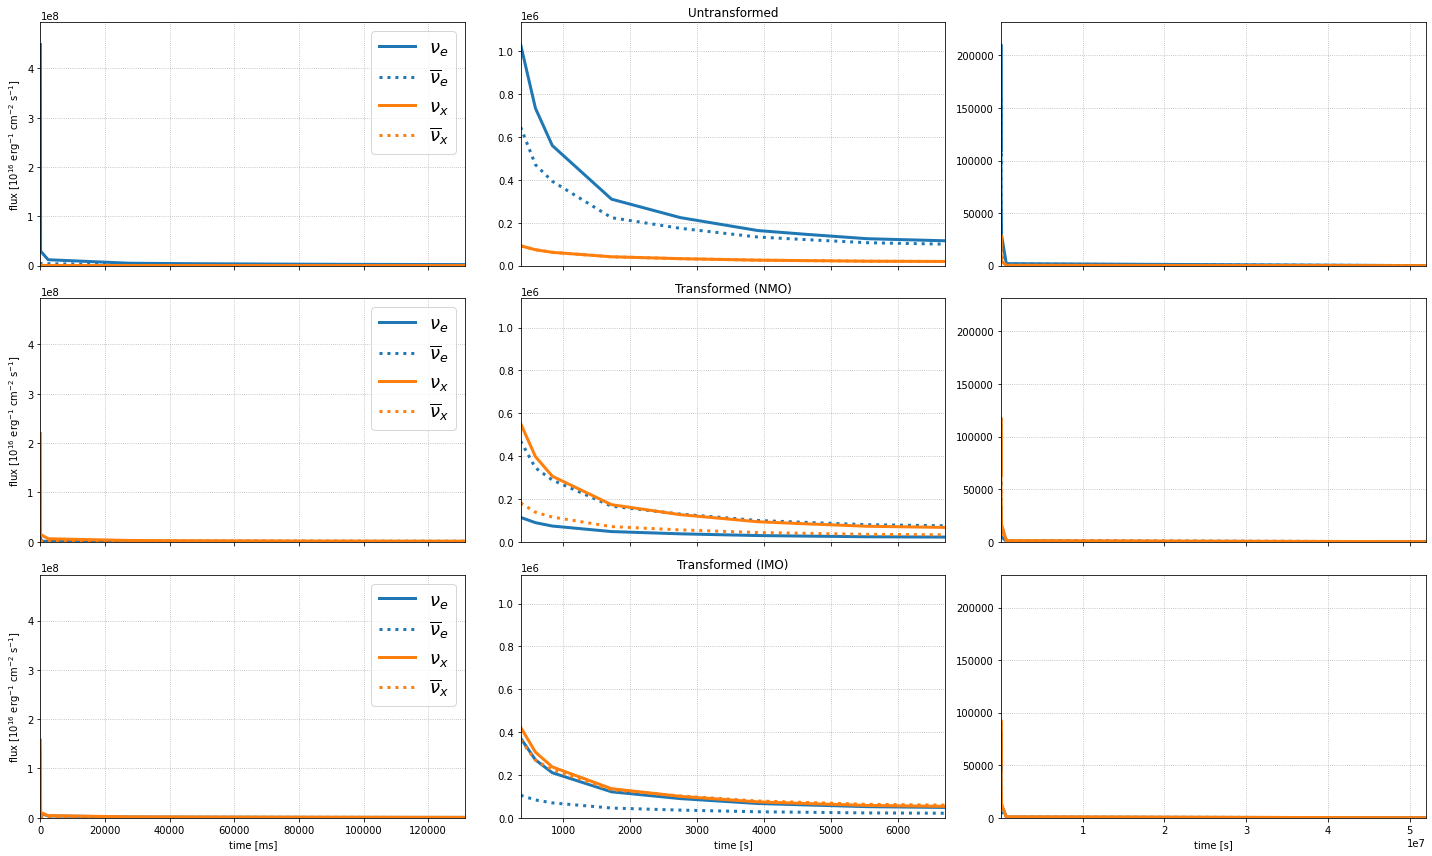

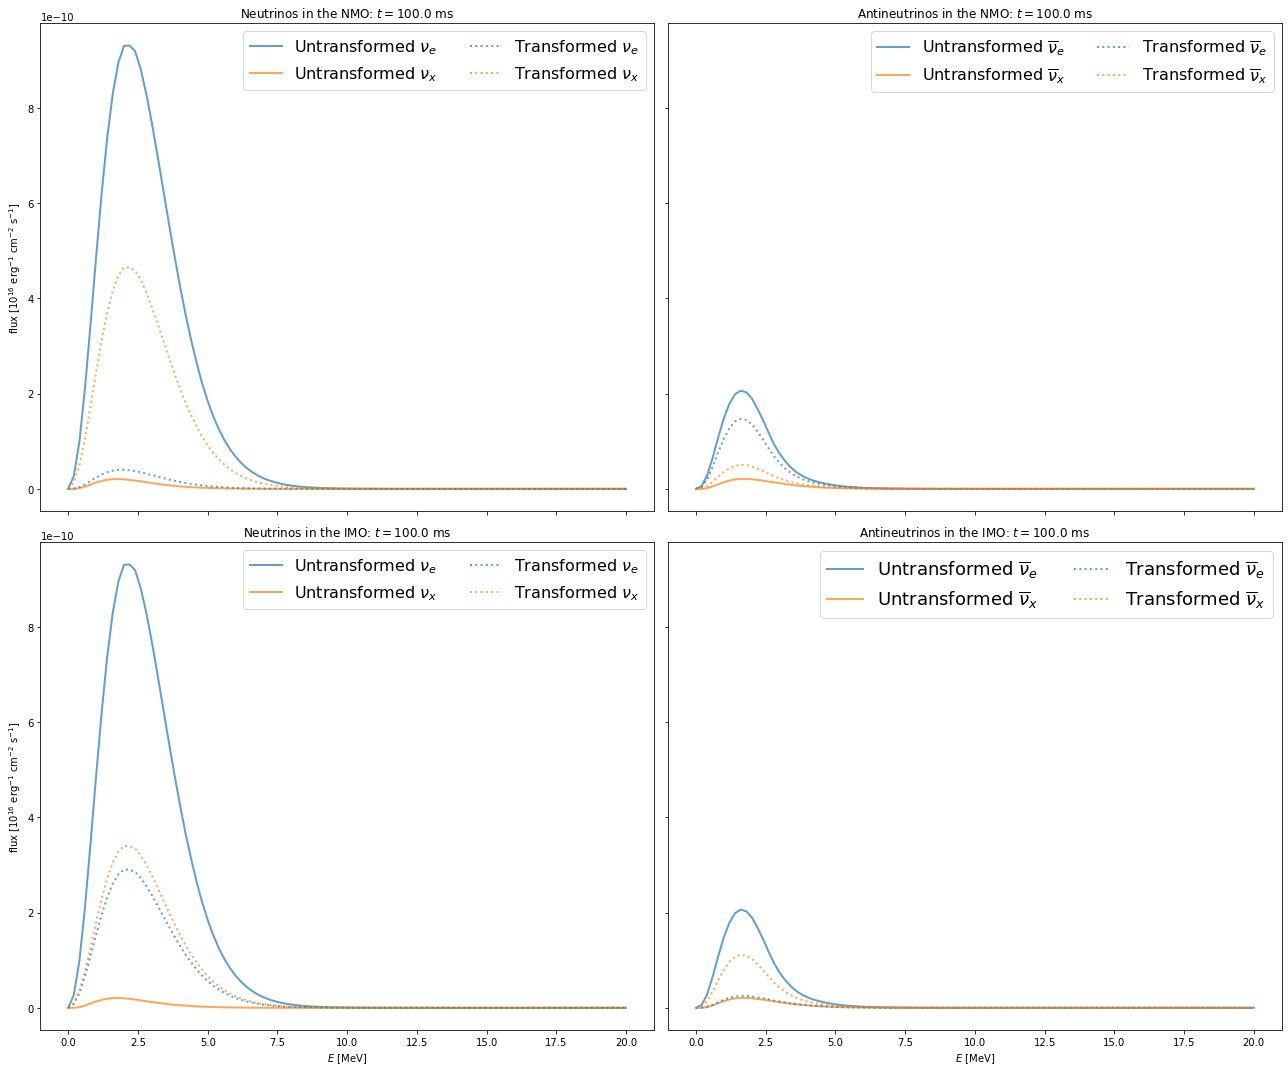

In [15]:
fig = plot_total_flux(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), presn=True)
fig.savefig('flux_adiabaticmsw.pdf')
fig = plot_spectra(model, AdiabaticMSW(), AdiabaticMSW(mh=MassHierarchy.INVERTED), 100*u.ms, presn=True)
fig.savefig('spectra_adiabaticmsw.pdf')


0 [ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False] [4.48424823e+08 2.95605943e+07 1.20111366e+07 4.94029326e+06
 3.99612449e+06 2.89909027e+06 2.16955903e+06 1.03240437e+06
 7.34934561e+05 5.60790458e+05 3.10422242e+05 2.24419870e+05
 1.63900382e+05 1.45652153e+05 1.25774952e+05 1.16126183e+05
 1.09567054e+05 1.29103449e+05 2.10364660e+05 7.29740580e+04
 2.90334271e+04 1.90735965e+03 3.44593758e+01]
0 [ True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False] [2.22312188e+06 4.43054768e+06 3.95873413e+06 2.27060673e+06
 2.05178233e+06 1.71357471e+06 1.31235685e+06 6.46835604e+05
 4.71323813e+05 3.93966487e+05 2.24028609e+05 1.74402177e+05
 1.33628153e+05 1.21144980e+05 1.07049290e+05 1.00361341e+05
 9.64486373e+04 1.13732819e+05 1.58410661e+05 5.74201390e+04
 2.05419126e+04 1.54442777e+03 2.85191756e+01]
0 [ True  

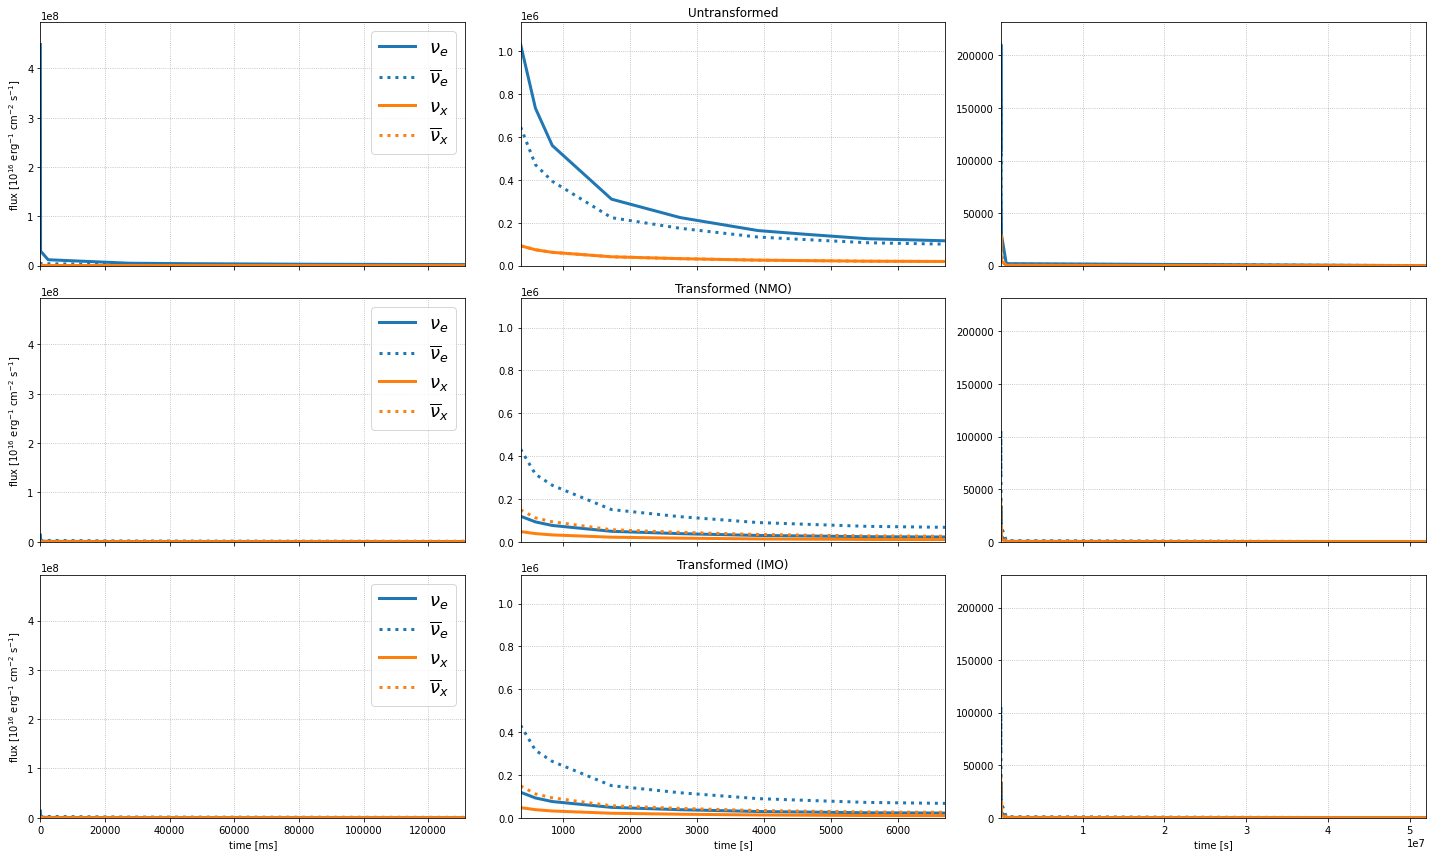

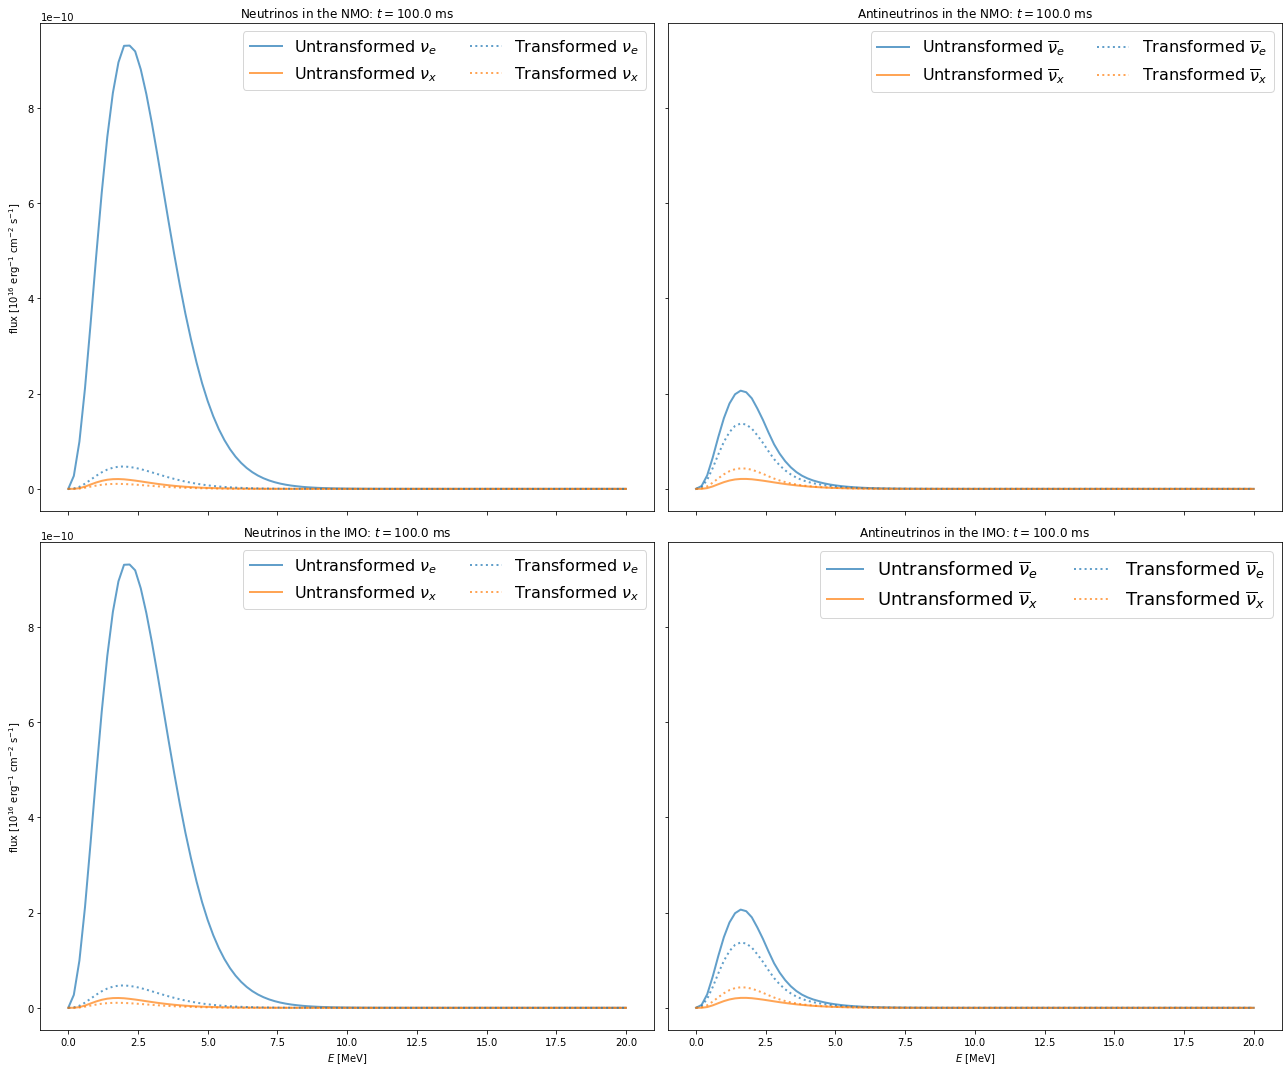

In [17]:
mp_nmo = MixingParameters()
angles_nmo = mp_nmo.get_mixing_angles() + (10*u.deg,)
xf_nmo = AdiabaticMSWes(angles_nmo)

mp_imo = MixingParameters(mh=MassHierarchy.INVERTED)
angles_imo = mp_imo.get_mixing_angles() + (10*u.deg,)
xf_imo = AdiabaticMSWes(angles_imo)

fig = plot_total_flux(model, xf_nmo, xf_imo, presn=True)
fig.savefig('flux_adiabaticmswes.pdf')
fig = plot_spectra(model, xf_nmo, xf_imo, 100*u.ms, presn=True)
fig.savefig('spectra_adiabaticmswes.pdf')
